In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import cv2
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer, DefaultDataCollator
from datasets import load_dataset

from sklearn.metrics import f1_score, precision_recall_fscore_support, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve, average_precision_score, precision_score, recall_score

In [2]:
# You should use your own dataset URL
dataset = load_dataset("e1010101/tongue-images-384-segmented-augmented")

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'labels', 'pixel_values'],
        num_rows: 1238
    })
    validation: Dataset({
        features: ['image', 'labels', 'pixel_values'],
        num_rows: 181
    })
    test: Dataset({
        features: ['image', 'labels', 'pixel_values'],
        num_rows: 94
    })
})

In [4]:
# Constants
num_classes = 3
class_names = ['Crack', 'Red-Dots', 'Toothmark']

In [13]:
tests = dataset['train'][0]['image']
print(type(tests))

<class 'PIL.PngImagePlugin.PngImageFile'>


In [17]:
if not isinstance(tests, np.ndarray):
    image = np.array(tests)

    if image.dtype != np.uint8:
        image_uint8 = (image * 255).astype(np.uint8)
    else:
        image_uint8 = image

    lab_image = cv2.cvtColor(image_uint8, cv2.COLOR_RGB2LAB)

    image_float = image_uint8.astype(np.float32) / 255.0  # Original image normalized to [0, 1]
    
    lab_image_float = lab_image.astype(np.float32)

    # Normalize L channel to [0, 1]
    lab_image_float[:, :, 0] /= 255.0

    # Normalize a and b channels from [0, 255] to [0, 1]
    lab_image_float[:, :, 1] = (lab_image_float[:, :, 1] - 128) / 127.0  # a channel to [-1, 1]
    lab_image_float[:, :, 2] = (lab_image_float[:, :, 2] - 128) / 127.0  # b channel to [-1, 1]
    lab_image_float[:, :, 1:] = (lab_image_float[:, :, 1:] + 1) / 2       # a and b channels to [0, 1]

    concatenated_image = np.concatenate((image_float, lab_image_float), axis=2).astype(np.float32)
        

In [9]:
def concatenate_lab_image_batch(examples):
    images = examples['image']
    concatenated_images = []
    for image in images:
        if not isinstance(image, np.ndarray):
            image = np.array(image)

        if image.dtype != np.uint8:
            image_uint8 = (image * 255).astype(np.uint8)
        else:
            image_uint8 = image

        lab_image = cv2.cvtColor(image_uint8, cv2.COLOR_RGB2LAB)
        
        print(image_uint8)

        image_float = image_uint8.astype(np.float32) / 255.0  # Original image normalized to [0, 1]
        lab_image_float = lab_image.astype(np.float32)

        # Normalize L channel to [0, 1]
        lab_image_float[:, :, 0] /= 255.0

        # Normalize a and b channels from [0, 255] to [0, 1]
        lab_image_float[:, :, 1] = (lab_image_float[:, :, 1] - 128) / 127.0  # a channel to [-1, 1]
        lab_image_float[:, :, 2] = (lab_image_float[:, :, 2] - 128) / 127.0  # b channel to [-1, 1]
        lab_image_float[:, :, 1:] = (lab_image_float[:, :, 1:] + 1) / 2       # a and b channels to [0, 1]

        concatenated_image = np.concatenate((image_float, lab_image_float), axis=2).astype(np.float32)
        concatenated_images.append(concatenated_image)

    examples['image'] = concatenated_images
    return examples

In [11]:
dataset = dataset.map(concatenate_lab_image_batch, batched=True, batch_size=10, writer_batch_size=10)

Map:   0%|          | 0/1238 [00:00<?, ? examples/s]

Map:   0%|          | 0/181 [00:00<?, ? examples/s]

Map:   0%|          | 0/94 [00:00<?, ? examples/s]

In [16]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'labels', 'pixel_values'],
        num_rows: 1238
    })
    validation: Dataset({
        features: ['image', 'labels', 'pixel_values'],
        num_rows: 181
    })
    test: Dataset({
        features: ['image', 'labels', 'pixel_values'],
        num_rows: 94
    })
})

# Model Development

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
model = AutoModelForImageClassification.from_pretrained(
    "google/vit-base-patch16-384",
    num_labels=3,
    problem_type="multi_label_classification",
    ignore_mismatched_sizes=True,
    id2label={0: 'Crack', 1: 'Red-Dots', 2: 'Toothmark'},
    label2id={'Crack': 0, 'Red-Dots': 1, 'Toothmark': 2}
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-384 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
model = model.to(device)

In [15]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probabilities = torch.sigmoid(torch.tensor(logits)).numpy()
    preds = (probabilities > 0.5).astype(int)
    
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='micro')
    
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Training

In [17]:
training_args = TrainingArguments(
    output_dir="./checkpoints/vit-384/segmented-augmented-dual-image/",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    greater_is_better=True
)

c:\Users\ezrat\anaconda3\envs\Standard\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [18]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    data_collator=DefaultDataCollator(),
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

# Validation

In [21]:
val_results = trainer.predict(dataset["validation"])

  0%|          | 0/12 [00:00<?, ?it/s]

In [22]:
val_logits = val_results.predictions
val_labels = val_results.label_ids

val_probabilities = torch.sigmoid(torch.tensor(val_logits)).numpy()

val_threshold = 0.5
val_preds = (val_probabilities > val_threshold).astype(int)

In [23]:
# Find optimal thresholds based on validation results
thresholds = np.arange(0.0, 1.01, 0.01)

optimal_thresholds = {}

for i, class_name in enumerate(class_names):
    best_threshold = 0.5
    best_f1 = 0.0
    
    for threshold in thresholds:
        preds = (val_probabilities[:, i] > threshold).astype(int)
        
        current_f1 = f1_score(val_labels[:, i], preds)
        
        if current_f1 > best_f1:
            best_f1 = current_f1
            best_threshold = threshold
    
    optimal_thresholds[class_name] = best_threshold
    print(f"Optimal threshold for '{class_name}': {best_threshold} with F1-score: {best_f1:.4f}")

Optimal threshold for 'Crack': 0.47000000000000003 with F1-score: 0.9007
Optimal threshold for 'Red-Dots': 0.46 with F1-score: 0.8889
Optimal threshold for 'Toothmark': 0.6 with F1-score: 0.8536


# Visualizations

In [24]:
df = pd.DataFrame(val_probabilities, columns=[f'prob_{cls}' for cls in class_names])
for idx, cls in enumerate(class_names):
    df[f'true_{cls}'] = val_labels[:, idx]

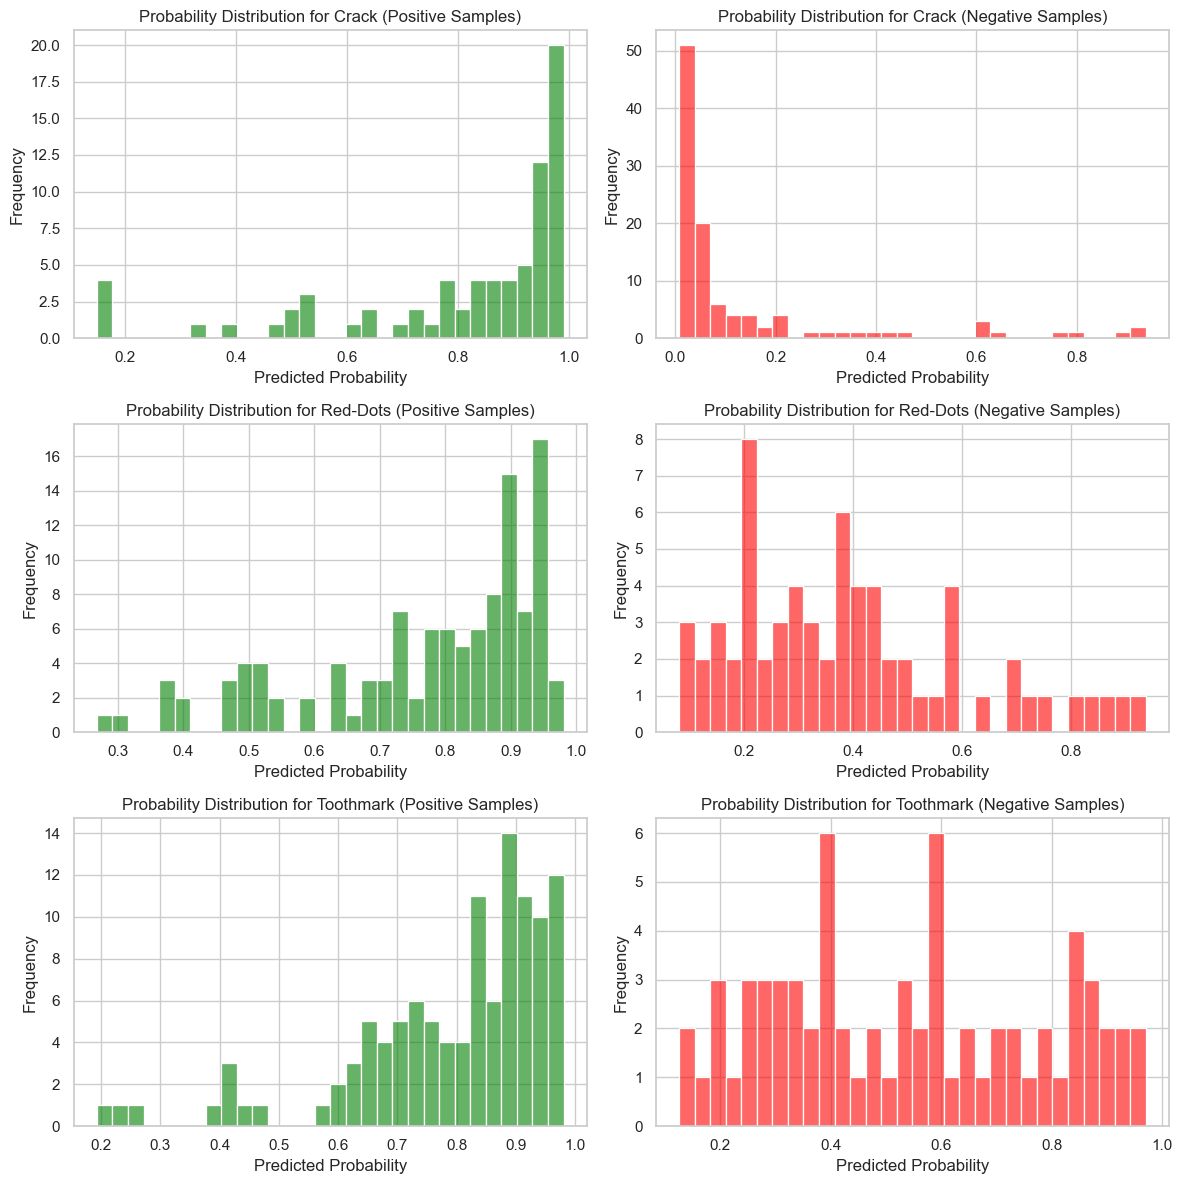

In [25]:
sns.set_theme(style="whitegrid")

fig, axes = plt.subplots(num_classes, 2, figsize=(12, 4 * num_classes))

for i, cls in enumerate(class_names):
    # Positive samples
    pos_probs = df[df[f'true_{cls}'] == 1][f'prob_{cls}']
    
    # Negative samples
    neg_probs = df[df[f'true_{cls}'] == 0][f'prob_{cls}']
    
    sns.histplot(pos_probs, bins=30, color='green', alpha=0.6, kde=False, ax=axes[i, 0])
    axes[i, 0].set_title(f'Probability Distribution for {cls} (Positive Samples)')
    axes[i, 0].set_xlabel('Predicted Probability')
    axes[i, 0].set_ylabel('Frequency')
    
    sns.histplot(neg_probs, bins=30, color='red', alpha=0.6, kde=False, ax=axes[i, 1])
    axes[i, 1].set_title(f'Probability Distribution for {cls} (Negative Samples)')
    axes[i, 1].set_xlabel('Predicted Probability')
    axes[i, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Model Coverage

In [37]:
def prec_line(thres_list, true_labels, pred_probs):
    prec_list = []
    for thres in thres_list:
        pred_pos = pred_probs > thres
        total_pred_pos = np.sum(pred_pos)
        
        if total_pred_pos == 0:
            precision = -0.01
        else:
            TP = np.sum((true_labels == 1) & pred_pos)
            FP = total_pred_pos - TP
            precision = TP / (TP + FP)

        prec_list.append(precision)
        
    return thres_list, prec_list

In [38]:
def spec_line(thres_list, true_labels, pred_probs):
    spec_list = []
    for thres in thres_list:
        pred_neg = pred_probs < thres
        total_pred_neg = np.sum(pred_neg)
        
        if total_pred_neg == 0:
            specificity = -0.01
        else:    
            TN = np.sum((true_labels == 0) & pred_neg)
            FN = total_pred_neg - TN
            specificity = TN / (TN + FN)

        spec_list.append(specificity)
        
    return thres_list, spec_list

(0.5, 1.0)

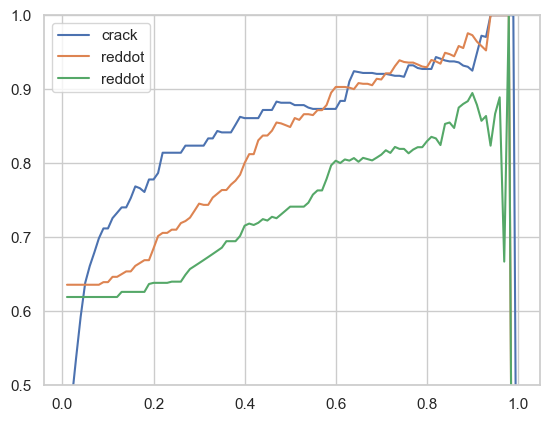

In [39]:
thres_list = np.arange(1, 0, -0.01)
true_labels_crack = df['true_Crack'].values
pred_probs_crack = df['prob_Crack'].values

true_labels_reddot = df['true_Red-Dots'].values
pred_probs_reddot = df['prob_Red-Dots'].values

true_labels_tooth = df['true_Toothmark'].values
pred_probs_tooth = df['prob_Toothmark'].values

_, prec_crack = prec_line(thres_list, true_labels_crack, pred_probs_crack)
_, prec_reddot = prec_line(thres_list, true_labels_reddot, pred_probs_reddot)
_, prec_tooth = prec_line(thres_list, true_labels_tooth, pred_probs_tooth)

plt.plot(thres_list, prec_crack, label='crack')
plt.plot(thres_list, prec_reddot, label='reddot')
plt.plot(thres_list, prec_tooth, label='reddot')
plt.legend()
plt.ylim(0.5, 1)

(0.5, 1.0)

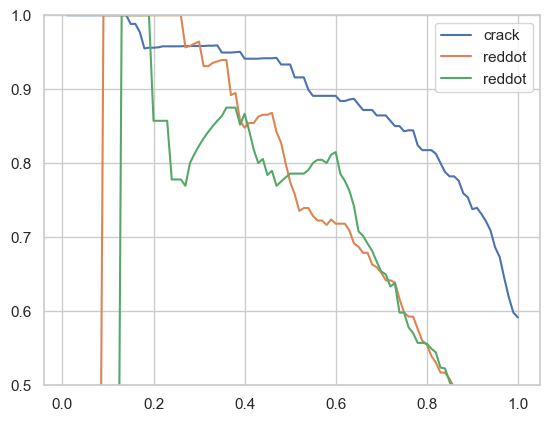

In [40]:
thres_list = np.arange(1, 0, -0.01)
true_labels_crack = df['true_Crack'].values
pred_probs_crack = df['prob_Crack'].values

true_labels_reddot = df['true_Red-Dots'].values
pred_probs_reddot = df['prob_Red-Dots'].values

true_labels_tooth = df['true_Toothmark'].values
pred_probs_tooth = df['prob_Toothmark'].values

_, spec_crack = spec_line(thres_list, true_labels_crack, pred_probs_crack)
_, spec_reddot = spec_line(thres_list, true_labels_reddot, pred_probs_reddot)
_, spec_tooth = spec_line(thres_list, true_labels_tooth, pred_probs_tooth)

plt.plot(thres_list, spec_crack, label='crack')
plt.plot(thres_list, spec_reddot, label='reddot')
plt.plot(thres_list, spec_tooth, label='reddot')
plt.legend()
plt.ylim(0.5, 1)

In [41]:
A_thresholds = {}
B_thresholds = {}

In [42]:
tmp = pd.DataFrame({'thres': thres_list, 'crack': prec_crack, 'reddot': prec_reddot, 'tooth': prec_tooth})
A_thresholds['Crack'] = tmp[tmp['crack']>=0.9]['thres'].min()
A_thresholds['Red-Dots'] = tmp[tmp['reddot']>=0.9]['thres'].min()
A_thresholds['Toothmark'] = tmp[tmp['tooth']>=0.9]['thres'].min()

In [43]:
tmp = pd.DataFrame({'thres': thres_list, 'crack': spec_crack, 'reddot': spec_reddot, 'tooth': spec_tooth})
B_thresholds['Crack'] = tmp[tmp['crack']>=0.9]['thres'].max()
B_thresholds['Red-Dots'] = tmp[tmp['reddot']>=0.9]['thres'].max()
B_thresholds['Toothmark'] = tmp[tmp['tooth']>=0.9]['thres'].max()

In [44]:
print(A_thresholds)
print(B_thresholds)

{'Crack': 0.6299999999999997, 'Red-Dots': 0.5999999999999996, 'Toothmark': 0.98}
{'Crack': 0.5299999999999996, 'Red-Dots': 0.35999999999999943, 'Toothmark': 0.18999999999999928}


In [45]:
for i, class_name in enumerate(class_names):
    threshold = A_thresholds[class_name]
    above_threshold_percentage = np.sum(val_probabilities[:, i] > threshold) / len(val_probabilities[:, i]) * 100
    print(f"Percentage of predictions above threshold A for {class_name}: {above_threshold_percentage:.2f}%")

Percentage of predictions above threshold A for Crack: 37.02%
Percentage of predictions above threshold A for Red-Dots: 56.91%
Percentage of predictions above threshold A for Toothmark: 0.55%


In [46]:
for i, class_name in enumerate(class_names):
    threshold = B_thresholds[class_name]
    below_threshold_percentage = np.sum(val_probabilities[:, i] < threshold) / len(val_probabilities[:, i]) * 100
    print(f"Percentage of predictions below threshold B for {class_name}: {below_threshold_percentage:.2f}%")

Percentage of predictions below threshold B for Crack: 59.12%
Percentage of predictions below threshold B for Red-Dots: 18.23%
Percentage of predictions below threshold B for Toothmark: 2.76%


# Testing

In [26]:
test_results = trainer.predict(dataset["test"])

  0%|          | 0/6 [00:00<?, ?it/s]

In [27]:
test_logits = test_results.predictions
test_labels = test_results.label_ids

test_probabilities = torch.sigmoid(torch.tensor(test_logits)).numpy()

test_preds = np.zeros_like(test_probabilities, dtype=int)
for i, class_name in enumerate(class_names):
    test_preds[:, i] = (test_probabilities[:, i] > optimal_thresholds[class_name]).astype(int)

# Evaluation

In [28]:
def calculate_class_accuracies(test_labels, test_preds, class_names):
    """
    Calculate the accuracy for each class in multi-label classification.
    
    Args:
        test_labels (numpy.ndarray): True labels for the test images.
        test_preds (numpy.ndarray): Predicted labels for the test images.
        class_names (list): List of class names.
    
    Returns:
        dict: A dictionary with class names as keys and their accuracies as values.
    """
    class_accuracies = {}
    for i, class_name in enumerate(class_names):
        correct_predictions = test_labels[:, i] == test_preds[:, i]
        accuracy = np.mean(correct_predictions)
        class_accuracies[class_name] = accuracy
    
    return class_accuracies

In [29]:
# Calculate class accuracies
class_accuracies = calculate_class_accuracies(test_labels, test_preds, class_names)

# Print accuracies for each class
print("Accuracy for each class:")
for class_name, accuracy in class_accuracies.items():
    print(f"{class_name}: {accuracy:.4f}")

# Calculate and print overall accuracy
overall_accuracy = np.mean(list(class_accuracies.values()))
print(f"\nOverall Accuracy: {overall_accuracy:.4f}")

Accuracy for each class:
Crack: 0.9255
Red-Dots: 0.7660
Toothmark: 0.7447

Overall Accuracy: 0.8121


# Classification Report

In [30]:
report = classification_report(test_labels, test_preds, target_names=class_names, zero_division=0)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       Crack       0.92      0.94      0.93        48
    Red-Dots       0.76      0.90      0.83        58
   Toothmark       0.85      0.78      0.82        68

   micro avg       0.84      0.86      0.85       174
   macro avg       0.85      0.87      0.86       174
weighted avg       0.84      0.86      0.85       174
 samples avg       0.76      0.77      0.75       174



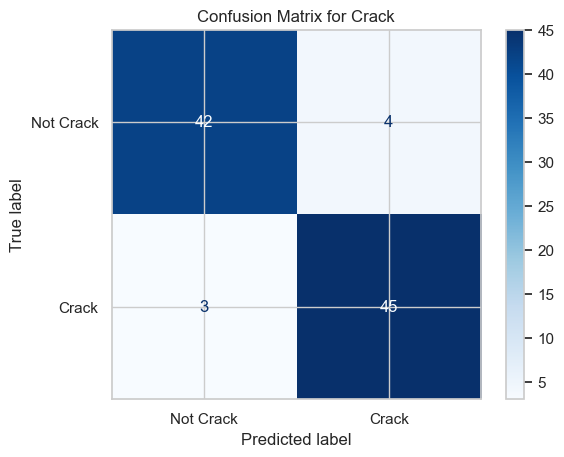

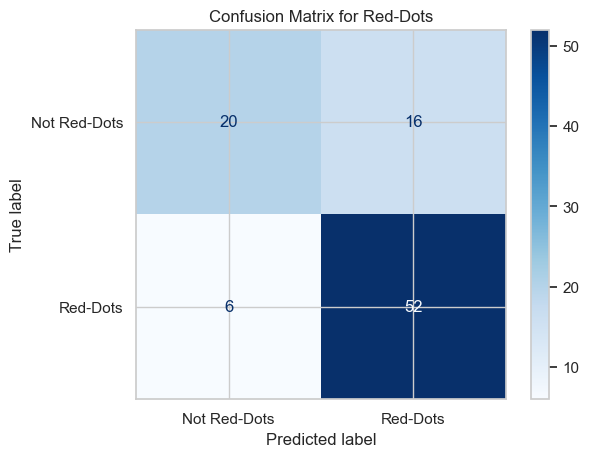

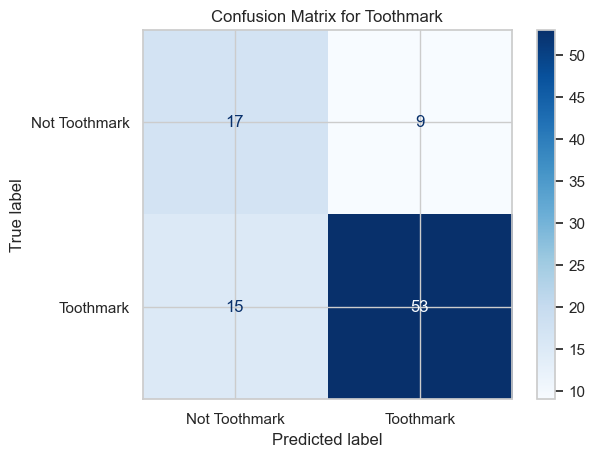

In [31]:
def plot_confusion_matrix_for_class(y_true, y_pred, class_name):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not ' + class_name, class_name])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {class_name}')
    plt.show()

for idx, class_name in enumerate(class_names):
    y_true = test_labels[:, idx]
    y_pred_class = test_preds[:, idx]
    plot_confusion_matrix_for_class(y_true, y_pred_class, class_name)

In [32]:
f1_micro = f1_score(test_labels, test_preds, average='micro')
f1_macro = f1_score(test_labels, test_preds, average='macro')

print(f"Micro F1-score: {f1_micro:.4f}")
print(f"Macro F1-score: {f1_macro:.4f}")

Micro F1-score: 0.8499
Macro F1-score: 0.8562


# Precision/Specificity

In [36]:
def get_precision_specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0 
    return precision, specificity

# Calculate precision and specificity for each class
for idx, class_name in enumerate(class_names):
    y_true = test_labels[:, idx]
    y_pred_class = test_preds[:, idx]
    precision, specificity = get_precision_specificity(y_true, y_pred_class)
    print(f"Class: {class_name}, Precision: {precision:.4f}, Specificity: {specificity:.4f}")


Class: Crack, Precision: 0.9184, Specificity: 0.9130
Class: Red-Dots, Precision: 0.7647, Specificity: 0.5556
Class: Toothmark, Precision: 0.8548, Specificity: 0.6538


# ROC/AUC

In [47]:
fpr = {}
tpr = {}
roc_auc = {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], test_preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

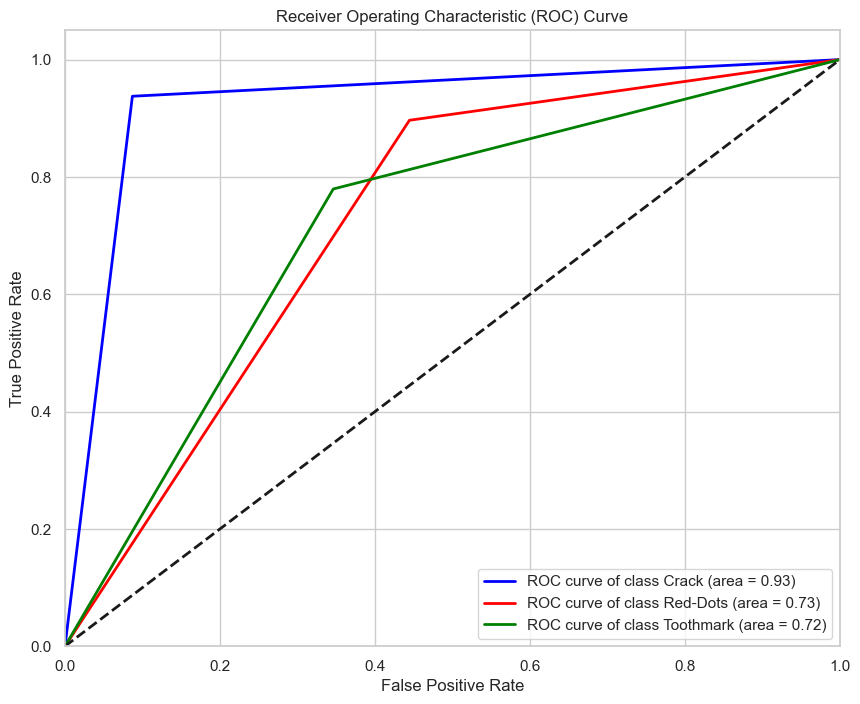

In [48]:
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green']
for i, color, class_name in zip(range(num_classes), colors, class_names):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
                label='ROC curve of class {0} (area = {1:0.2f})'
                ''.format(class_name, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Precision/Recall AUC

In [49]:
precision = {}
recall = {}
average_precision = {}

for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(test_labels[:, i], test_preds[:, i])
    average_precision[i] = average_precision_score(test_labels[:, i], test_preds[:, i])

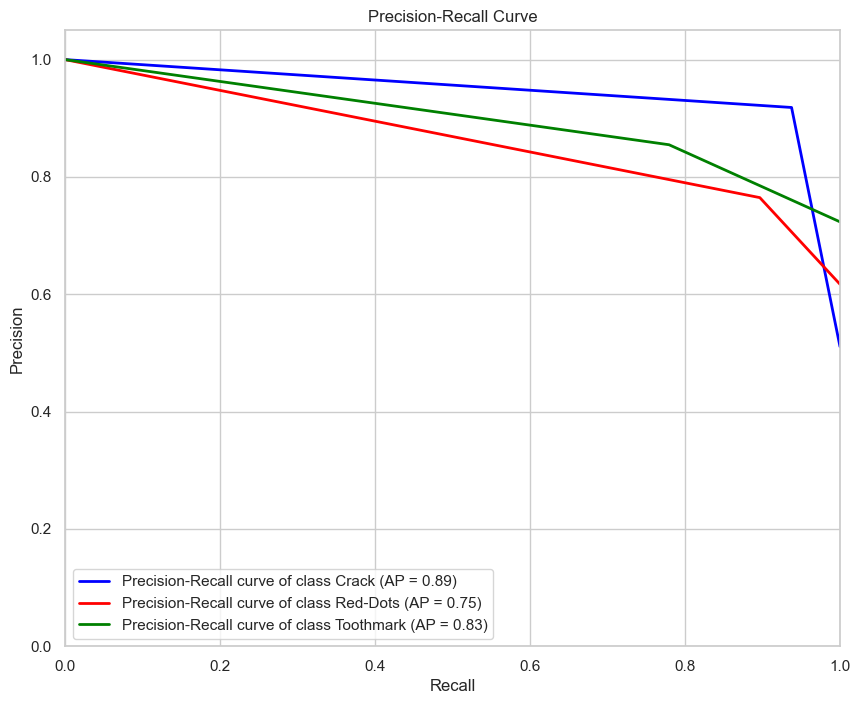

In [50]:
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green']

for i, color, class_name in zip(range(num_classes), colors, class_names):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label=f'Precision-Recall curve of class {class_name} '
                   f'(AP = {average_precision[i]:0.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

# Number of Uncertain Predictions

In [51]:
### Number of Uncertain Predictions

uncertainty_threshold = 0.05  # Define your uncertainty threshold (e.g., 0.05 for predictions within +/- 5% of 0.5)

uncertain_counts = {}

for i, class_name in enumerate(class_names):
    uncertain_count = np.sum((test_probabilities[:, i] >= (0.5 - uncertainty_threshold)) & (test_probabilities[:, i] <= (0.5 + uncertainty_threshold)))
    uncertain_counts[class_name] = uncertain_count
    print(f"Number of uncertain predictions for {class_name}: {uncertain_count}")

total_uncertain = sum(uncertain_counts.values())
print(f"\nTotal number of uncertain predictions (across all classes): {total_uncertain}")


Number of uncertain predictions for Crack: 2
Number of uncertain predictions for Red-Dots: 15
Number of uncertain predictions for Toothmark: 12

Total number of uncertain predictions (across all classes): 29
